<a href="https://colab.research.google.com/github/hazanyucel/Medikal-Goruntu-Isleme-medical-image-processing-/blob/main/AttentionUNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

🚀 Kullanılan Cihaz: cuda
Eğitim Verisi: 1625 | Doğrulama Verisi: 287

🔥 Eğitim Başlıyor...


Epoch 1/15: 100%|██████████| 102/102 [01:59<00:00,  1.17s/it, loss=1.56]


Epoch 1 -> Loss: 1.7884 | Val Dice: 0.0856
💾 Model Kaydedildi (New Best)!


Epoch 2/15: 100%|██████████| 102/102 [01:19<00:00,  1.28it/s, loss=1.33]


Epoch 2 -> Loss: 1.4461 | Val Dice: 0.7219
💾 Model Kaydedildi (New Best)!


Epoch 3/15: 100%|██████████| 102/102 [01:20<00:00,  1.27it/s, loss=1.12]


Epoch 3 -> Loss: 1.2197 | Val Dice: 0.6764


Epoch 4/15: 100%|██████████| 102/102 [01:20<00:00,  1.27it/s, loss=1.22]


Epoch 4 -> Loss: 1.0625 | Val Dice: 0.8284
💾 Model Kaydedildi (New Best)!


Epoch 5/15: 100%|██████████| 102/102 [01:20<00:00,  1.27it/s, loss=0.886]


Epoch 5 -> Loss: 0.9364 | Val Dice: 0.8654
💾 Model Kaydedildi (New Best)!


Epoch 6/15: 100%|██████████| 102/102 [01:20<00:00,  1.27it/s, loss=0.738]


Epoch 6 -> Loss: 0.8167 | Val Dice: 0.8460


Epoch 7/15: 100%|██████████| 102/102 [01:20<00:00,  1.27it/s, loss=0.566]


Epoch 7 -> Loss: 0.6950 | Val Dice: 0.8920
💾 Model Kaydedildi (New Best)!


Epoch 8/15: 100%|██████████| 102/102 [01:20<00:00,  1.27it/s, loss=0.574]


Epoch 8 -> Loss: 0.5924 | Val Dice: 0.8821


Epoch 9/15: 100%|██████████| 102/102 [01:20<00:00,  1.27it/s, loss=0.508]


Epoch 9 -> Loss: 0.5027 | Val Dice: 0.8715


Epoch 10/15: 100%|██████████| 102/102 [01:20<00:00,  1.27it/s, loss=0.485]


Epoch 10 -> Loss: 0.4294 | Val Dice: 0.8312


Epoch 11/15: 100%|██████████| 102/102 [01:20<00:00,  1.27it/s, loss=0.218]


Epoch 11 -> Loss: 0.3713 | Val Dice: 0.8896


Epoch 12/15: 100%|██████████| 102/102 [01:20<00:00,  1.27it/s, loss=0.347]


Epoch 12 -> Loss: 0.3314 | Val Dice: 0.8907


Epoch 13/15: 100%|██████████| 102/102 [01:20<00:00,  1.27it/s, loss=0.405]


Epoch 13 -> Loss: 0.3093 | Val Dice: 0.9068
💾 Model Kaydedildi (New Best)!


Epoch 14/15: 100%|██████████| 102/102 [01:20<00:00,  1.26it/s, loss=0.202]


Epoch 14 -> Loss: 0.2753 | Val Dice: 0.9182
💾 Model Kaydedildi (New Best)!


Epoch 15/15: 100%|██████████| 102/102 [01:20<00:00,  1.27it/s, loss=0.22]


Epoch 15 -> Loss: 0.2524 | Val Dice: 0.9105

🏆 En İyi Validation Dice Skoru: 0.9182

🖼️ 10 Rastgele Örnek Çiziliyor...


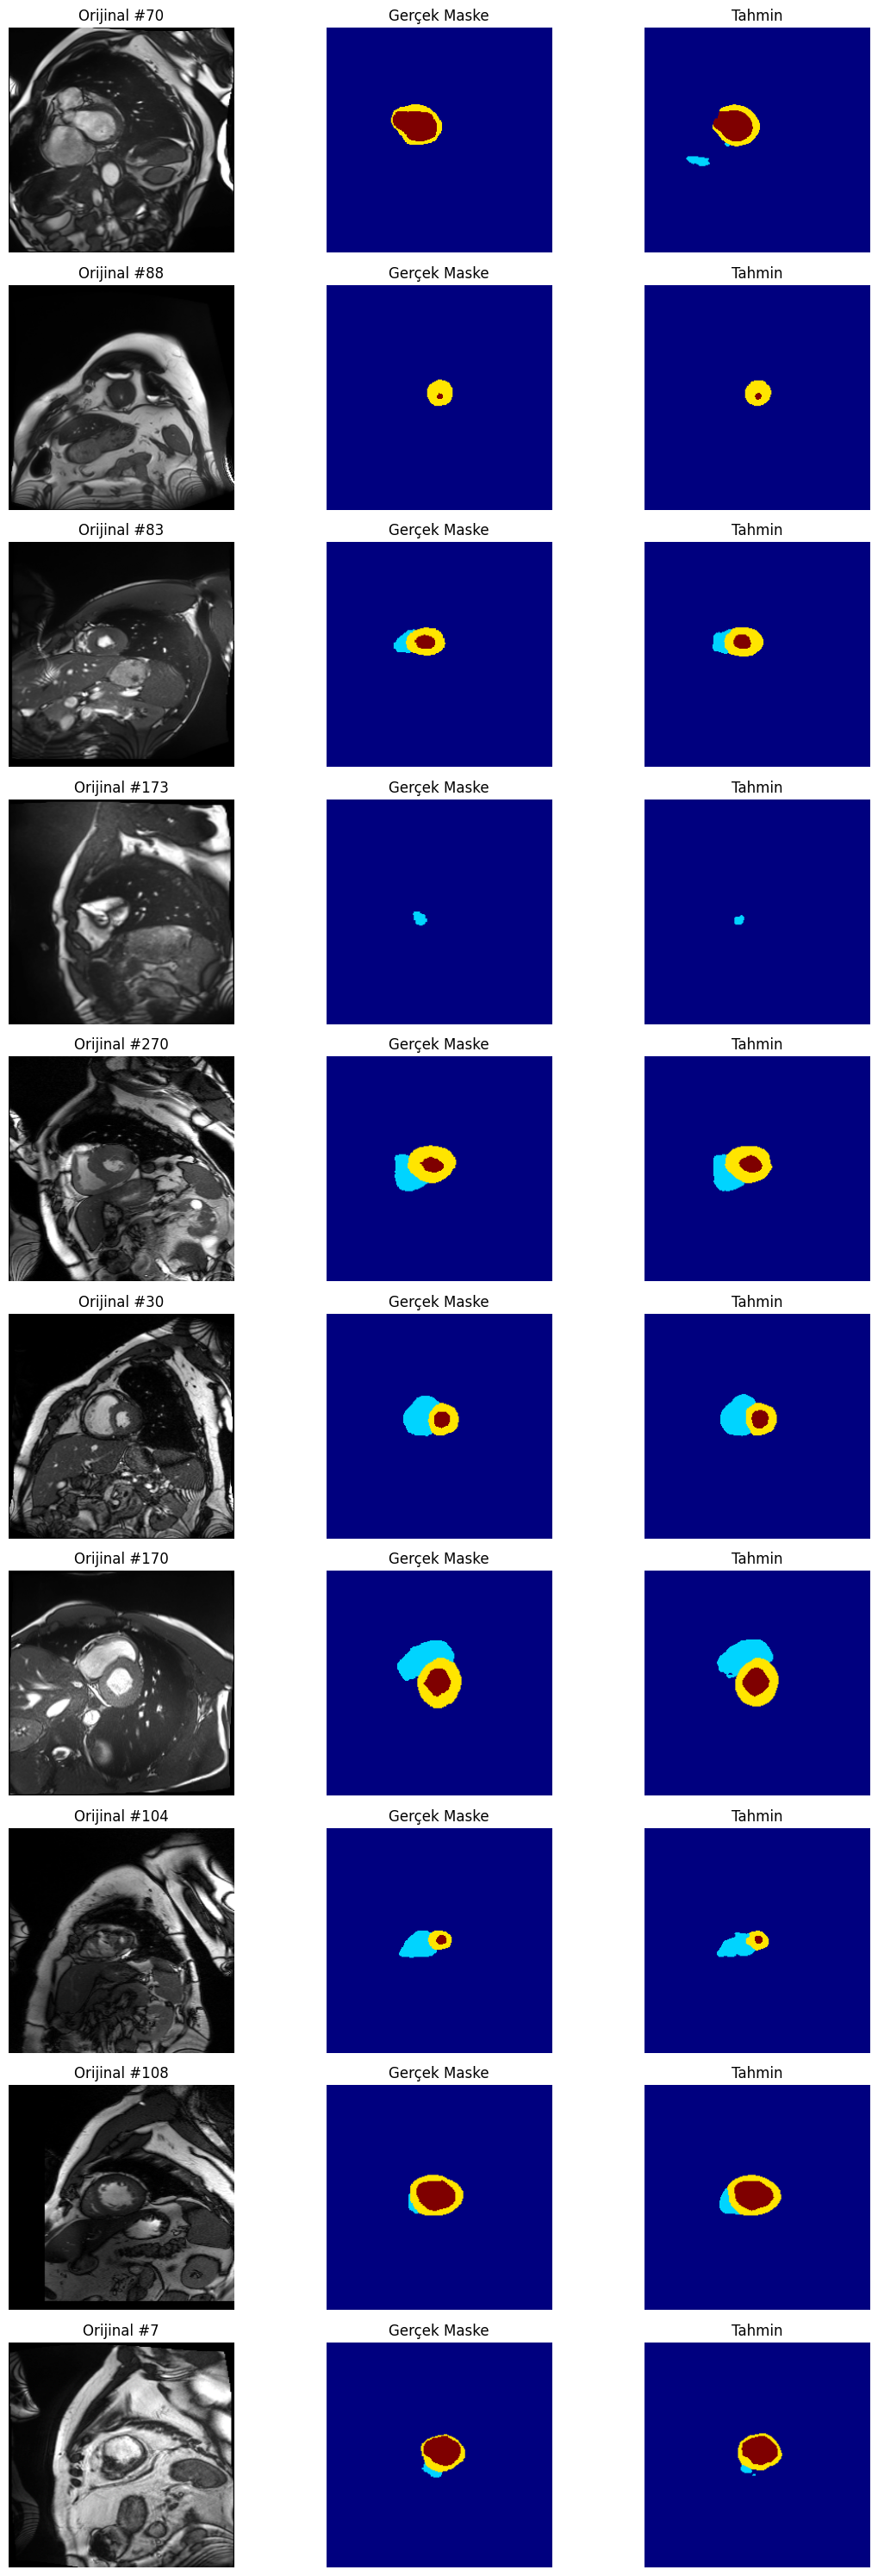

In [ ]:
# ===============================
# 1. KÜTÜPHANELER VE AYARLAR
# ===============================
import os
import h5py
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
from tqdm import tqdm  # İlerleme çubuğu için

# GPU Kontrolü
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🚀 Kullanılan Cihaz: {device}")

# ===============================
# 2. AYARLAR (CONFIG)
# ===============================
DATASET_PATH = "/content/drive/MyDrive/archive/ACDC_preprocessed/ACDC_training_slices" # BURAYI KONTROL ET
BATCH_SIZE = 16    # Pro GPU için 32 yapabilirsin
EPOCHS = 15        # Hız için düşürüldü
LR = 1e-4          # Learning Rate
TARGET_SIZE = (256, 256)

# ===============================
# 3. GÜNCELLENMİŞ DATASET CLASS
# ===============================
class ACDCSliceDataset(Dataset):
    def __init__(self, root_dir, target_size=(256, 256)):
        self.files = sorted([
            os.path.join(root_dir, f)
            for f in os.listdir(root_dir)
            if f.endswith(".h5")
        ])
        self.target_size = target_size

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        try:
            with h5py.File(self.files[idx], 'r') as f:
                # Veri setindeki anahtar ismini bul (image/slice)
                img_key = list(f.keys())[0] if 'image' not in f.keys() else 'image'
                lbl_key = list(f.keys())[1] if 'label' not in f.keys() else 'label' # Genelde 2. anahtar labeldir

                image = f[img_key][:]
                label = f[lbl_key][:]
        except Exception as e:
            # Hatalı dosya varsa boş döndür (Eğitimde atlamak için)
            print(f"Hata: {self.files[idx]} - {e}")
            return torch.zeros((1, *self.target_size)), torch.zeros(self.target_size)

        # Numpy -> Tensor
        image = torch.tensor(image, dtype=torch.float32).unsqueeze(0) # (1, H, W)
        label = torch.tensor(label, dtype=torch.long).unsqueeze(0)    # (1, H, W)

        # 1. Resize (Interpolation)
        image = F.interpolate(image.unsqueeze(0), size=self.target_size, mode="bilinear", align_corners=False).squeeze(0)
        label = F.interpolate(label.unsqueeze(0).float(), size=self.target_size, mode="nearest").squeeze(0).long()

        # 2. NORMALİZASYON (Kritik Ekleme!)
        # Görüntüyü 0-1 aralığına çekiyoruz
        if image.max() > 0:
            image = (image - image.min()) / (image.max() - image.min() + 1e-8)

        return image, label.squeeze(0) # Label (H, W) formatında döner

# ===============================
# 4. MODEL MİMARİSİ (ATTENTION U-NET)
# ===============================
class ConvBlock(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_c, out_c, 3, padding=1),
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_c, out_c, 3, padding=1),
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True)
        )
    def forward(self, x): return self.block(x)

class AttentionGate(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super().__init__()
        self.W_g = nn.Conv2d(F_g, F_int, 1)
        self.W_x = nn.Conv2d(F_l, F_int, 1)
        self.psi = nn.Conv2d(F_int, 1, 1)
    def forward(self, g, x):
        psi = torch.sigmoid(self.psi(F.relu(self.W_g(g) + self.W_x(x))))
        return x * psi

class AttentionUNet(nn.Module):
    def __init__(self, num_classes=4):
        super().__init__()
        self.enc1 = ConvBlock(1, 64)
        self.enc2 = ConvBlock(64, 128)
        self.enc3 = ConvBlock(128, 256)
        self.pool = nn.MaxPool2d(2)
        self.bottleneck = ConvBlock(256, 512)

        self.up3 = nn.ConvTranspose2d(512, 256, 2, 2)
        self.att3 = AttentionGate(256, 256, 128)
        self.dec3 = ConvBlock(512, 256)

        self.up2 = nn.ConvTranspose2d(256, 128, 2, 2)
        self.att2 = AttentionGate(128, 128, 64)
        self.dec2 = ConvBlock(256, 128)

        self.up1 = nn.ConvTranspose2d(128, 64, 2, 2)
        self.att1 = AttentionGate(64, 64, 32)
        self.dec1 = ConvBlock(128, 64)

        self.out = nn.Conv2d(64, num_classes, 1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        b = self.bottleneck(self.pool(e3))

        d3 = self.up3(b)
        e3 = self.att3(d3, e3)
        d3 = self.dec3(torch.cat([d3, e3], dim=1))

        d2 = self.up2(d3)
        e2 = self.att2(d2, e2)
        d2 = self.dec2(torch.cat([d2, e2], dim=1))

        d1 = self.up1(d2)
        e1 = self.att1(d1, e1)
        d1 = self.dec1(torch.cat([d1, e1], dim=1))
        return self.out(d1)

# ===============================
# 5. LOSS & METRİKLER
# ===============================
def dice_loss(pred, target, eps=1e-6):
    pred = torch.softmax(pred, dim=1)
    target_onehot = F.one_hot(target, num_classes=4).permute(0,3,1,2).float()
    inter = (pred * target_onehot).sum(dim=(2,3))
    union = pred.sum(dim=(2,3)) + target_onehot.sum(dim=(2,3))
    # Ortalama Dice Loss (Background hariç 1,2,3 sınıfları için)
    dice = (2 * inter + eps) / (union + eps)
    return 1 - dice[:, 1:].mean() # Background'ı loss'a katmayabiliriz veya katabiliriz.

def calculate_dice_metric(pred, target, num_classes=4):
    dices = []
    pred = torch.argmax(pred, dim=1)
    for cls in range(1, num_classes): # Background (0) hariç
        pred_c = (pred == cls).float()
        target_c = (target == cls).float()
        inter = (pred_c * target_c).sum()
        union = pred_c.sum() + target_c.sum()
        dice = (2 * inter + 1e-6) / (union + 1e-6)
        dices.append(dice.item())
    return np.mean(dices)

# ===============================
# 6. VERİ YÜKLEME VE MODEL HAZIRLIĞI
# ===============================
# Veri seti
full_dataset = ACDCSliceDataset(DATASET_PATH, target_size=TARGET_SIZE)
if len(full_dataset) == 0:
    raise ValueError("Veri bulunamadı! DATASET_PATH yolunu kontrol et.")

train_size = int(0.85 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_ds, val_ds = random_split(full_dataset, [train_size, val_size])

print(f"Eğitim Verisi: {len(train_ds)} | Doğrulama Verisi: {len(val_ds)}")

# Dataloader
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

# Model
model = AttentionUNet(num_classes=4).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss()

# ===============================
# 7. EĞİTİM DÖNGÜSÜ (GELİŞMİŞ)
# ===============================
best_val_dice = 0.0
train_losses = []
val_dices = []

print("\n🔥 Eğitim Başlıyor...")

for epoch in range(EPOCHS):
    # --- TRAINING ---
    model.train()
    epoch_loss = 0
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}")

    for img, lbl in loop:
        img, lbl = img.to(device), lbl.to(device)

        optimizer.zero_grad()
        out = model(img)

        loss = criterion(out, lbl) + dice_loss(out, lbl)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        loop.set_postfix(loss=loss.item())

    avg_train_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # --- VALIDATION ---
    model.eval()
    val_dice_score = 0
    with torch.no_grad():
        for img, lbl in val_loader:
            img, lbl = img.to(device), lbl.to(device)
            out = model(img)
            val_dice_score += calculate_dice_metric(out, lbl)

    avg_val_dice = val_dice_score / len(val_loader)
    val_dices.append(avg_val_dice)

    print(f"Epoch {epoch+1} -> Loss: {avg_train_loss:.4f} | Val Dice: {avg_val_dice:.4f}")

    # En iyi modeli kaydet
    if avg_val_dice > best_val_dice:
        best_val_dice = avg_val_dice
        torch.save(model.state_dict(), "best_att_unet.pth")
        print("💾 Model Kaydedildi (New Best)!")

print(f"\n🏆 En İyi Validation Dice Skoru: {best_val_dice:.4f}")

# ===============================
# 8. SONUÇLARI GÖRSELLEŞTİRME (10 ÖRNEK)
# ===============================
print("\n🖼️ 10 Rastgele Örnek Çiziliyor...")

# En iyi modeli yükle
model.load_state_dict(torch.load("best_att_unet.pth"))
model.eval()

# Rastgele 10 index seç
indices = np.random.choice(len(val_ds), 10, replace=False)

plt.figure(figsize=(12, 30)) # Uzun bir figür

for i, idx in enumerate(indices):
    img, lbl = val_ds[idx] # CPU Tensor

    # Tahmin yap
    with torch.no_grad():
        input_tensor = img.unsqueeze(0).to(device) # (1, 1, 256, 256)
        pred_logits = model(input_tensor)
        pred_mask = torch.argmax(pred_logits, dim=1).squeeze(0).cpu().numpy()

    img_np = img.squeeze(0).numpy()
    lbl_np = lbl.numpy()

    # Görselleştirme
    plt.subplot(10, 3, i*3 + 1)
    plt.imshow(img_np, cmap="gray")
    plt.title(f"Orijinal #{idx}")
    plt.axis("off")

    plt.subplot(10, 3, i*3 + 2)
    plt.imshow(lbl_np, cmap="jet", vmin=0, vmax=3)
    plt.title("Gerçek Maske")
    plt.axis("off")

    plt.subplot(10, 3, i*3 + 3)
    plt.imshow(pred_mask, cmap="jet", vmin=0, vmax=3)
    plt.title(f"Tahmin")
    plt.axis("off")

plt.tight_layout()
plt.show()